In [2]:
import camb
import numpy as np
import matplotlib.pyplot as plt
from lensit.clusterlens import lensingmap, profile 
import os.path as op

***could not import FINUFFT, falling back on fortran bicubic implementation


In [3]:
def cli(cl):
    ret = np.zeros_like(cl)
    ret[np.where(cl > 0)] = 1. / cl[np.where(cl > 0)]
    return ret

def pp_to_kk(ls):
    return ls ** 2 * (ls+1.) ** 2 * 0.25 

def kk_to_pp(ls):
    return cli(pp_to_kk(ls))

def th_amin_to_el(th_amin):
    th_rd = (th_amin/60)*(np.pi/180)
    return np.pi/th_rd

In [53]:
# We start by intiating CAMB which will give us the relevant cosmology 
cambinifile = 'planck_2018_acc'

pars = camb.read_ini(op.join(op.dirname('/Users/sayan/CMB_WORK/CAMB-1.1.3/inifiles'),  'inifiles', cambinifile + '.ini'))
results = camb.get_results(pars)

In [57]:
# We define here the parameters for the profile of the cluster
M200, z, xmaxn = 9 * 1e14, 0.45, 10
profname = 'nfw'
key = "cluster" # "lss"/"cluster"/"lss_plus_cluster"
profparams={'M200c':M200, 'z':z, 'xmaxn': xmaxn}
hprofile = profile.profile(results, profname)
xmax = xmaxn*hprofile.get_concentration(M200, z)
# Define here the map square patches
npix = 60  # Number of pixels
lpix_amin = 0.5 # Physical size of a pixel in arcmin (There is bug when <0.2 amin, due to low precision in Cl_TE at )

print("The size of the data patch is %0.1f X %0.1f arcmin central box"%(npix*lpix_amin, npix*lpix_amin))

# Maximum multipole used to generate the CMB maps from the CMB power spectra
# ellmaxsky = 6000 # (bug when ellmax>6300 because of low precision in Cl_TE of CAMB )
ellmaxsky = 6000 

# Set the maximum ell observed in the CMB data maps
ellmaxdat = 4000
ellmindat = 100

# Number of simulated maps 
nsims = 1

# Set CMB experiment for noise level and beam
cmb_exp='S4_sayan'

# We will cache things in this directory 
libdir = lensingmap.get_cluster_libdir(cambinifile,  profname, key, npix, lpix_amin, ellmaxsky, M200, z, nsims, cmb_exp)
#libdir = op.join(libdir,"trunc")
print(libdir)

The size of the data patch is 30.0 X 30.0 arcmin central box
/Users/sayan/Project_Geneva/modules/lensit_sims/temp/clustermaps/camb_planck_2018_acc/cmbexp_S4_sayan/nfw_profile/lensed_by_cluster/npix60_lpix_0.5amin_lmaxsky6000/M200_9.000000E+14_z0.45/1_sims


In [58]:
lmax = ellmaxsky
cpp_fid = results.get_lens_potential_cls(lmax=lmax, raw_cl=True).T[0]

camb_cls = results.get_unlensed_scalar_cls(CMB_unit='muK', raw_cl=True, lmax=lmax).T
cls_unl_fid = {'tt':camb_cls[0], 'ee':camb_cls[1], 'bb':camb_cls[2], 'te':camb_cls[3], 'pp':cpp_fid}

camb_cls_len = results.get_lensed_scalar_cls(CMB_unit='muK', raw_cl=True, lmax=lmax).T
cls_len_fid = {'tt':camb_cls_len[0], 'ee':camb_cls_len[1], 'bb':camb_cls_len[2], 'te':camb_cls_len[3], 'pp':cpp_fid}

In [59]:
np.random.seed(seed=20)
clustermaps = lensingmap.cluster_maps(libdir, key, npix, lpix_amin, nsims, results, profparams, profilename=profname,  ellmax_sky = ellmaxsky, ellmax_data=ellmaxdat, ellmin_data=ellmindat, cmb_exp=cmb_exp)

 [00:00:00] Generating CMB phases > 00%
 [00:00:00] Generating Noise phases > 00%


In [60]:
ell = np.arange(2, ellmaxsky)

cl_anal = hprofile.analitic_kappa_ft(M200, z, xmax, ell)

In [62]:
nz = 100 #number of steps to use for the radial/redshift integration
kmax=10  #kmax to use
from camb import model, initialpower

#chistar = results.conformal_time(0)- results.tau_maxvis
chistar = results.comoving_radial_distance(z=1)
chis = np.linspace(0,chistar,nz)
zs=results.redshift_at_comoving_radial_distance(chis)
#Calculate array of delta_chi, and drop first and last points where things go singular
dchis = (chis[2:]-chis[:-2])/2
chis = chis[1:-1]
zs = zs[1:-1]

#Get the matter power spectrum interpolation object (based on RectBivariateSpline). 
#Here for lensing we want the power spectrum of the Weyl potential.
PK = camb.get_matter_power_interpolator(pars, nonlinear=True, 
    hubble_units=False, k_hunit=False, kmax=kmax,
    var1=model.Transfer_Weyl,var2=model.Transfer_Weyl, zmax=zs[-1])

#Have a look at interpolated power spectrum results for a range of redshifts
#Expect linear potentials to decay a bit when Lambda becomes important, and change from non-linear growth
k=np.exp(np.log(10)*np.linspace(-4,2,200))


In [64]:
#Get lensing window function (flat universe)
win = ((chistar-chis)/(chis**2*chistar))**2
#Do integral over chi
ls = np.arange(2,ellmaxsky+1, dtype=np.float64)
cl_kappa=np.zeros(ls.shape)
w = np.ones(chis.shape) #this is just used to set to zero k values out of range of interpolation
for i, l in enumerate(ls):
    k=(l+0.5)/chis
    w[:]=1
    w[k<1e-4]=0
    w[k>=kmax]=0
    cl_kappa[i] = np.dot(dchis, w*PK.P(zs, k, grid=False)*win/k**4)
cl_kappa*= (ls*(ls+1))**2

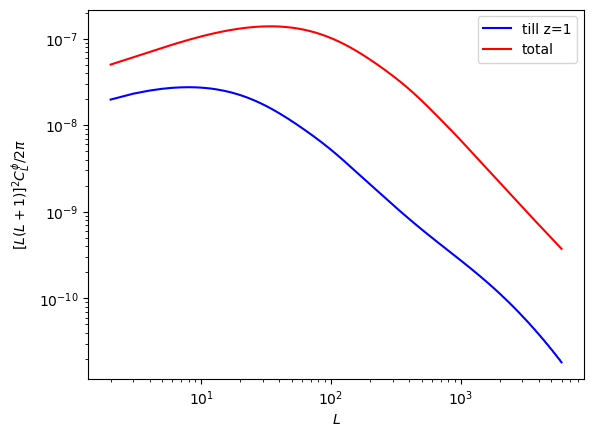

In [66]:
#Compare with CAMB's calculation:
#note that to get CAMB's internal calculation accurate at the 1% level at L~2000, 
#need lens_potential_accuracy=2. Increase to 4 for accurate match to the Limber calculation here
#pars.set_for_lmax(2500,lens_potential_accuracy=2)
#results = camb.get_results(pars)
cl_camb=results.get_lens_potential_cls(ellmaxsky) 
#cl_camb[:,0] is phi x phi power spectrum (other columns are phi x T and phi x E)

#Make plot. Expect difference at very low-L from inaccuracy in Limber approximation, and
#very high L from differences in kmax (lens_potential_accuracy is only 2, though good by eye here)
cl_limber= 4*cl_kappa/2/np.pi #convert kappa power to [l(l+1)]^2C_phi/2pi (what cl_camb is)
plt.loglog(ls,cl_limber, color='b')
plt.loglog(np.arange(2,cl_camb[:,0].size),cl_camb[2:,0], color='r')
#plt.xlim([1,2000])
plt.legend(['till z=1','total'])
plt.ylabel('$[L(L+1)]^2C_L^{\phi}/2\pi$')
plt.xlabel('$L$');

[]

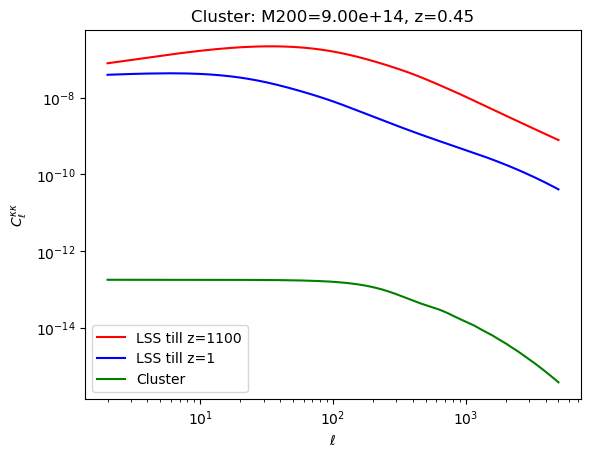

In [95]:
ell = np.arange(0, 5000)
#plt.plot(ell[2:], pp_to_kk(ell[2:])*cl_lss[ell[2:]], label='CAMB')
#plt.plot(ell[2:], pp_to_kk(ell[2:])*cls_unl_fid['pp'][ell[2:]], label='LSS')
plt.plot(ell[2:],cl_camb[ell[2:],0]* 2 * np.pi/4, color='r', label='LSS till z=1100')
plt.plot(ell[2:], cl_limber[ell[2:]]*2*np.pi/4, color='b', label='LSS till z=1')
plt.plot(ell[2:], cl_anal[ell[2:]]**2 / 4/np.pi, color='g', label='Cluster')
plt.xlabel(r'$\ell$')
plt.ylabel(r'$C_{\ell}^{\kappa\kappa}$')
plt.title('Cluster: M200=%0.2e, z=%0.2f'%(M200, z))
plt.legend()
plt.loglog()


In [85]:
ell.shape

(6000,)